목표: 객관적인 데이터와 과거 경기 기록을 이용해 우승팀을 예측한다.

- 데이터: 
    - FIFA 선수 데이터
    - 국가대표 경기 결과

In [3]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 import
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 한글 사용
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
df_matches = pd.read_csv('data/all_matches.csv') # 현재까지의 모든 국가대표 경기 결과
df_fifa = pd.read_csv('data/fifa_fbref_merged.csv') # FIFA 선수 데이터

/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_15492/4008758656.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fifa = pd.read_csv('data/fifa_fbref_merged.csv') # FIFA 선수 데이터


In [ ]:
# 결측치 및 이상치 제거

# 결측치 제거
df_matches.dropna(subset=['home_score', 'away_score'], inplace=True)

# 이상치 제거
df_matches = df_matches[
    (df_matches['home_score'] >= 0) & 
    (df_matches['away_score'] >= 0) &
    (df_matches['home_score'] <= 20) &
    (df_matches['away_score'] <= 20)
]

### 최근 3년 국가별 승률

국가별 승/무/패 기록을 종합하여 최근 3년간의 승률을 시각화

/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_15492/1090884101.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valid_teams.head(15).index, y=valid_teams.head(15)['Win Rate'], palette='Oranges_r')


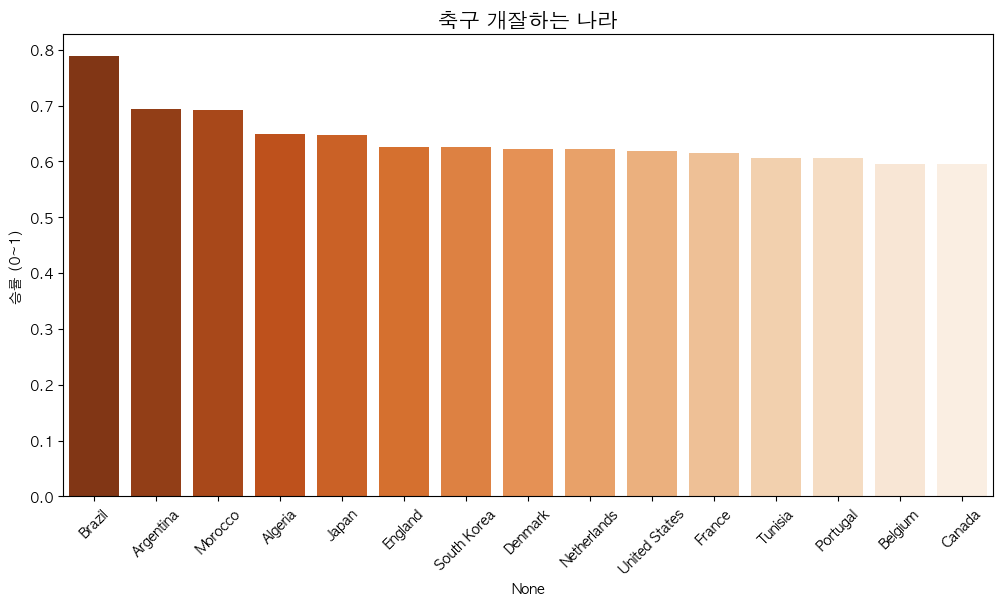

In [18]:
# 날짜 변환 및 최근 3년 데이터 필터링 (2020~2022)
df_matches['date'] = pd.to_datetime(df_matches['date'])

# 2022년 기준 최근 3년 (2020, 2021, 2022)
matches_recent = df_matches[
    (df_matches['date'].dt.year >= 2020) & 
    (df_matches['date'].dt.year <= 2022)
].copy()

# 홈/원정 결과 벡터화 (Vectorized)
# 홈 팀 결과
matches_recent['home_win'] = (matches_recent['home_score'] > matches_recent['away_score']).astype(int)
matches_recent['home_loss'] = (matches_recent['home_score'] < matches_recent['away_score']).astype(int)
matches_recent['draw'] = (matches_recent['home_score'] == matches_recent['away_score']).astype(int)

# 원정 팀 결과 (홈 결과의 반대)
matches_recent['away_win'] = matches_recent['home_loss'] # Away win if Home loss
matches_recent['away_loss'] = matches_recent['home_win'] # Away loss if Home win
# 무승부는 동일하게 적용

# 팀별 집계
    # 홈 경기 통계 집계
home_stats = matches_recent.groupby('home_team')[['home_win', 'draw', 'home_loss']].sum()
home_stats['total_games'] = home_stats['home_win'] + home_stats['draw'] + home_stats['home_loss']
home_stats.rename(columns={'home_win': 'wins', 'home_loss': 'losses'}, inplace=True)

    # 원정 경기 통계 집계
away_stats = matches_recent.groupby('away_team')[['away_win', 'draw', 'away_loss']].sum()
away_stats['total_games'] = away_stats['away_win'] + away_stats['draw'] + away_stats['away_loss']
away_stats.rename(columns={'away_win': 'wins', 'away_loss': 'losses'}, inplace=True)

    # 홈 및 원정 통계 합산
total_stats = home_stats.add(away_stats, fill_value=0)

    # 승률 계산
total_stats['Win Rate'] = total_stats['wins'] / total_stats['total_games']

    # 10경기 이상 치른 팀 필터링
valid_teams = total_stats[total_stats['total_games'] >= 30].sort_values('Win Rate', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=valid_teams.head(15).index, y=valid_teams.head(15)['Win Rate'], palette='Oranges_r')
plt.title('축구 개잘하는 나라', fontsize=15)
plt.ylabel('승률 (0~1)')
plt.xticks(rotation=45)
plt.show()


### 국가별 평균나이 대비 승률 상관관계 시각화

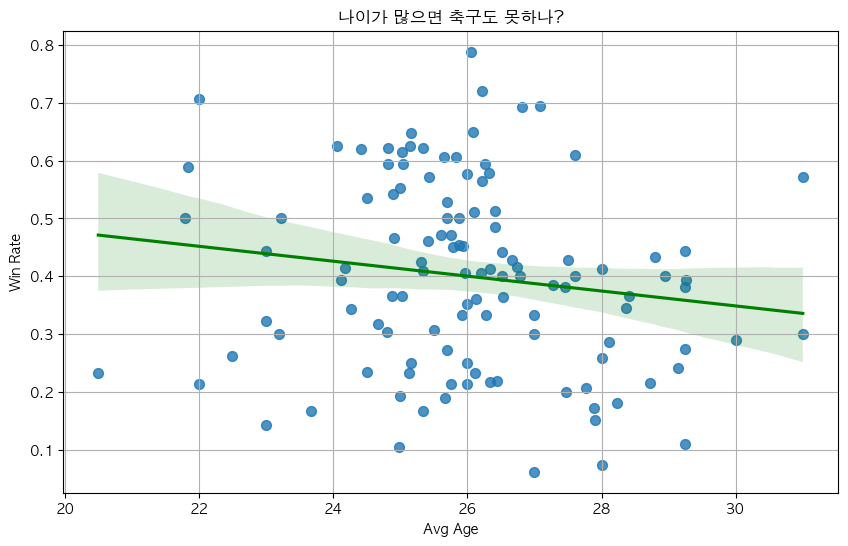

In [8]:
# 최근 3년 평균 나이 추출
age_data = []
target_versions = [20, 21, 22]
for v in target_versions:
    df_v = df_fifa[df_fifa['fifa_version'] == v]
    if len(df_v) > 0:
        # 국가별 평균 나이
        age_v = df_v.groupby('nationality_name')['age_fifa'].mean()
        age_data.append(age_v)

if age_data:
    avg_age_df = pd.concat(age_data, axis=1).mean(axis=1).to_frame(name='Avg Age')
else:
    avg_age_df = pd.DataFrame(columns=['Avg Age'])

viz_teams = valid_teams.copy()
name_map = {'South Korea': 'Korea Republic', 'United States': 'United States'}
viz_teams.rename(index=name_map, inplace=True)

age_corr_df = pd.merge(viz_teams['Win Rate'], avg_age_df, left_index=True, right_index=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg Age', y='Win Rate', data=age_corr_df, scatter_kws={'s': 50}, line_kws={'color':'green'})
plt.title('나이가 많으면 축구도 못하나?')
plt.grid(True)
plt.show()

USE_AGE_FEATURE = True

## 수치가 매우 크지는 않지만 평균나이가 높을수록 승률이 떨어지는 경향을 보인다.

### 2. 2022년 국가별 전력 분석 (FIFA 데이터)
- 2022년 당시 각 국가의 평균 전력을 계산하고, 앞서 구한 승률과의 관계를 봅니다.
- 국가대표팀에는 수십 명의 선수가 있지만, 실제 경기는 11명이 뛴다.   
- 433포메이션을 기준으로 공격수 3명, 미드필더 3명, 수비수 4명, 골키퍼 1명의 상위 11명의 평균만을 추출하여 그 팀의 진짜 전력을 측정
- 2022년과 2026년을 예측할 때 시점별 최근 3년간 데이터만 이용하도록 했다.

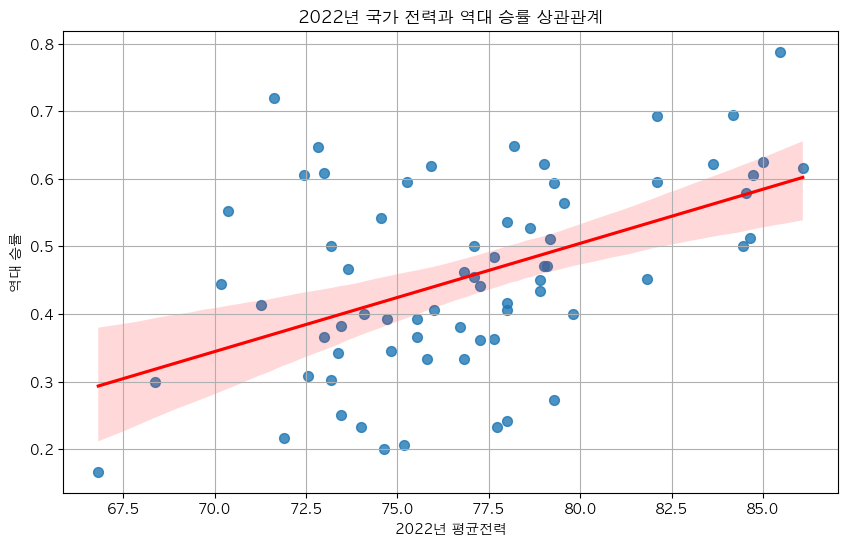

In [15]:
# 전력 및 평균나이 계산 함수 (4-3-3 기준)
def get_team_power(year):
    target_version = int(str(year)[-2:])
    
    df_year = df_fifa[df_fifa['fifa_version'] == target_version].copy()
    if len(df_year) == 0:
        print(f"Warning: No data for version {target_version}")
        return pd.DataFrame()

    def map_pos(p):
        if 'GK' in p: return 'GK'
        elif any(x in p for x in ['B', 'CB', 'WB']): return 'DF'
        elif any(x in p for x in ['M', 'W']): return 'MF'
        else: return 'FW'
    
    df_year['simple_pos'] = df_year['player_positions'].apply(map_pos)
    
    team_powers = []
    for nation, group in df_year.groupby('nationality_name'):
        best_11 = []
        best_11_ages = []
        # 4-3-3 포메이션
        for pos, count in [('FW', 3), ('MF', 3), ('DF', 4), ('GK', 1)]:
            # 포지션별 Overall 상위 추출
            top = group[group['simple_pos'] == pos].nlargest(count, 'overall')
            best_11.extend(top['overall'].tolist())
            best_11_ages.extend(top['age_fifa'].tolist())
            
            if len(top) < count:
                 rem = count - len(top)
                 others = group[~group.index.isin(top.index)].nlargest(rem, 'overall')
                 best_11.extend(others['overall'].tolist())
                 best_11_ages.extend(others['age_fifa'].tolist())
        
        if len(best_11) >= 11:
            avg_power = np.mean(best_11)
            avg_age = np.mean(best_11_ages)
            team_powers.append({'Team': nation, 'Power': avg_power, 'AvgAge': avg_age})
            
    return pd.DataFrame(team_powers)

power_2022 = get_team_power(2022)

# 승률 데이터와 병합하여 상관관계 시각화 (Power vs Win Rate)
# (기존 코드 유지)
merged_viz = pd.merge(power_2022, valid_teams['Win Rate'], left_on='Team', right_index=True)

plt.figure(figsize=(10, 6))
sns.regplot(x='Power', y='Win Rate', data=merged_viz, scatter_kws={'s': 50}, line_kws={'color':'red'})
plt.title('2022년 국가 전력과 역대 승률 상관관계')
plt.xlabel('2022년 평균전력')
plt.ylabel('역대 승률')
plt.grid(True)
plt.show()


### 3. AI 모델 학습 (80% 학습, 20% 테스트)
- **특징**: 단순 승률이 아니라, '경기 당시의 양 팀 전력 차이'를 학습시킵니다.
- **데이터**: 2018~2022년 경기 데이터와 당시 FIFA 스탯을 연결합니다.

In [10]:
# 학습용 데이터셋 구축
# 날짜 데이터 확인 및 변환
df_matches['date'] = pd.to_datetime(df_matches['date'])
train_matches = df_matches[(df_matches['date'].dt.year >= 2018) & (df_matches['date'].dt.year <= 2022)].copy()

dataset = []

# 연도별 전력
power_cache = {}
for y in range(2018, 2023):
    p_df = get_team_power(y)
    if not p_df.empty:
        # 인덱스로 설정 후 dict 변환
        power_cache[y] = p_df.set_index('Team')[['Power', 'AvgAge']].to_dict('index')

# 전역 변수 USE_AGE_FEATURE 가 없으면 기본값 False 처리 (안전장치)
if 'USE_AGE_FEATURE' not in locals():
    USE_AGE_FEATURE = False

for idx, row in train_matches.iterrows():
    year = row['date'].year
    if year not in power_cache: continue
    
    p_map = power_cache[year]
    
    t1, t2 = row['home_team'], row['away_team']
    if t1 == 'South Korea': t1 = 'Korea Republic'
    if t2 == 'South Korea': t2 = 'Korea Republic'
    
    if t1 in p_map and t2 in p_map:
        p1_data = p_map[t1]
        p2_data = p_map[t2]
        
        score_diff = row['home_score'] - row['away_score']
        
        # Features
        # 기본: Power 차이 / 옵션: Age 차이
        p_diff = p1_data['Power'] - p2_data['Power']
        
        if USE_AGE_FEATURE:
            a_diff = p1_data['AvgAge'] - p2_data['AvgAge']
            dataset.append({'Power_Diff': p_diff, 'Age_Diff': a_diff, 'Result': score_diff})
            # 대칭 데이터
            dataset.append({'Power_Diff': -p_diff, 'Age_Diff': -a_diff, 'Result': -score_diff})
        else:
            dataset.append({'Power_Diff': p_diff, 'Result': score_diff})
            dataset.append({'Power_Diff': -p_diff, 'Result': -score_diff})

df_train = pd.DataFrame(dataset)

# Feature 선택
if USE_AGE_FEATURE:
    X = df_train[['Power_Diff', 'Age_Diff']]
else:
    X = df_train[['Power_Diff']]

y = df_train['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습

# 여러 모델 정의
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

best_model = None
best_score = -np.inf
results = {}

print("=== 모델 성능 비교 (R2 Score) ===")
for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        y_pred_m = m.predict(X_test)
        score = r2_score(y_test, y_pred_m)
        results[name] = score
        print(f"{name}: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_model = m
    except Exception as e:
        print(f"{name} 실패: {str(e)}")

print(f"\n🏆 최적 모델: {best_model.__class__.__name__} {best_score:.4f}")

# 선택된 모델을 'model' 변수에 할당하여 이후 코드와 호환 유지
model = best_model


=== 모델 성능 비교 (R2 Score) ===
RandomForest: 0.0254
XGBoost: 0.0480

🏆 최적 모델: XGBRegressor 0.0480


### 4. 모델 검증: 2022 월드컵 우승팀 예측
- 학습된 AI에게 2022년 전력을 주고 시뮬레이션을 돌립니다.
- **목표**: 실제 우승팀인 **Argentina**를 맞추는지 확인합니다.

In [ ]:
# 검증 대상 국가 (2022 16강 진출 위주 주요국)
candidates_2022 = [
    'Argentina', 'France', 'Croatia', 'Morocco', 'Netherlands', 'England', 'Brazil', 'Portugal',
    'Japan', 'Senegal', 'Australia', 'Korea Republic', 'Spain', 'USA', 'Switzerland', 'Poland'
]

power_22_map = power_cache[2022] # 위에서 계산해둔 2022 전력 사용

points = {t: 0 for t in candidates_2022}

import itertools  # 수학적인 조합(경우의 수)을 계산해주는 도구를 가져옵니다.

# itertools.combinations: 참가국(candidates_2022) 중에서 2팀씩 짝지을 수 있는 모든 경우의 수를 만듭니다.
# 마치 월드컵 예선처럼 모든 팀이 서로 한 번씩 대결하는 반복문입니다.
# 예: (한국 vs 일본), (한국 vs 브라질), (일본 vs 브라질) ...
for t1, t2 in itertools.combinations(candidates_2022, 2):
    
    # 만약 전력 데이터가 없는 팀이 있다면 계산하지 않고 건너뜁니다.
    if t1 not in power_22_map or t2 not in power_22_map: continue
    
    # 두 팀의 데이터(전력, 나이 등)를 딕셔너리에서 꺼내옵니다.
    p1_data = power_22_map[t1]  # 1번 팀 정보
    p2_data = power_22_map[t2]  # 2번 팀 정보
    
    # [핵심 변수] 두 팀의 '전력 차이'를 계산합니다. (1번 팀 전력 - 2번 팀 전력)
    # 값이 양수(+)면 1번 팀이 강한 것이고, 음수(-)면 2번 팀이 강한 것입니다.
    p_diff = p1_data['Power'] - p2_data['Power']
    
    # [입력값 준비] '평균 나이(Age)' 정보를 사용할지 결정하는 부분입니다.
    if 'USE_AGE_FEATURE' in locals() and USE_AGE_FEATURE:
        # 나이 정보를 쓴다면, '나이 차이'도 계산해서 추가합니다.
        a_diff = p1_data['AvgAge'] - p2_data['AvgAge']
        # AI에게 줄 질문지: [전력 차이, 나이 차이]
        pred_input = [[p_diff, a_diff]]
    else:
        # 나이 정보를 안 쓴다면, AI에게 줄 질문지: [전력 차이]
        pred_input = [[p_diff]]
        
    # [AI 예측] 학습된 모델(심판)에게 물어봅니다.
    # "이 정도 전력 차이라면, 점수 차이가 얼마나 날까?" -> 결과값(pred_diff) 반환
    pred_diff = model.predict(pred_input)[0]
    
    # [승점 부여] 예측 결과에 따라 실제 축구 규칙(승점 3점)을 적용합니다.
    if pred_diff > 0.5: 
        points[t1] += 3      # 예측 점수 차가 0.5보다 크면 -> 1번 팀 승리 (승점 3점)
    elif pred_diff < -0.5: 
        points[t2] += 3      # 예측 점수 차가 -0.5보다 작으면 -> 2번 팀 승리 (승점 3점)
    else: 
        points[t1] += 1      # 점수 차가 애매하면(-0.5 ~ 0.5 사이) -> 무승부
        points[t2] += 1      # 두 팀 모두 승점 1점씩 획득

# 결과 출력
ranking_2022 = pd.DataFrame(list(points.items()), columns=['Team', 'Points']).sort_values('Points', ascending=False)
display(ranking_2022.head())

winner_2022 = ranking_2022.iloc[0]['Team']

,Team,Points
6,Brazil,33
5,England,28
1,France,27
4,Netherlands,26
0,Argentina,23


AI는 2022월드컵 우승팀을 브라질로 예측했다.(실패함)    
실제 우승팀은 아르헨티나이므로 틀렸지만 그래도 순위권에는 들어와있으니 2026년 월드컵도 예측해본다.

### 5. 2026 월드컵 우승팀 예측
- 직전 모델에 2025년 데이터를 입력하여 2026년월드컵 우승팀을 예측해본다.

/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_15492/2300306043.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Team', y='Points', data=ranking_2026.head(), palette='magma')


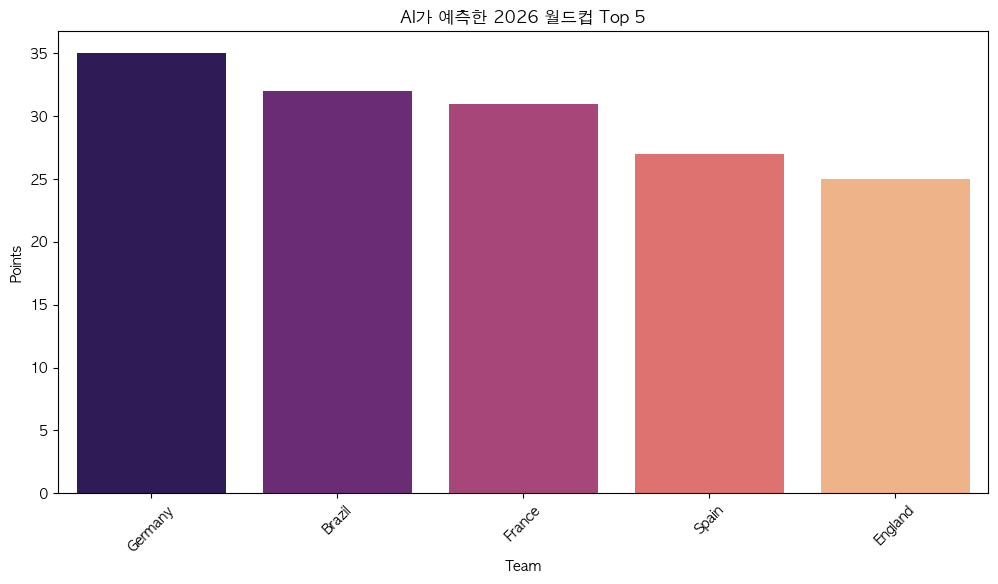

In [12]:
# FIFA 25 데이터 로드
power_2026_df = get_team_power(2025)
power_26_map = power_2026_df.set_index('Team')[['Power', 'AvgAge']].to_dict('index')

# 주요 참가국
candidates_2026 = [
    'Argentina', 'France', 'England', 'Brazil', 'Spain', 'Germany', 'Portugal', 'Netherlands', 'Italy',
    'Croatia', 'Uruguay', 'Belgium', 'Japan', 'Korea Republic', 'USA', 'Mexico', 'Morocco'
]

points_26 = {t: 0 for t in candidates_2026}

for t1, t2 in itertools.combinations(candidates_2026, 2):
    if t1 not in power_26_map or t2 not in power_26_map: 
        continue
    
    p1_data = power_26_map[t1]
    p2_data = power_26_map[t2]
    
    p_diff = p1_data['Power'] - p2_data['Power']
    
    if USE_AGE_FEATURE:
        a_diff = p1_data['AvgAge'] - p2_data['AvgAge']
        pred_input = [[p_diff, a_diff]]
    else:
        pred_input = [[p_diff]]
        
    pred_diff = model.predict(pred_input)[0]
    
    if pred_diff > 0.5: points_26[t1] += 3
    elif pred_diff < -0.5: points_26[t2] += 3
    else: 
        points_26[t1] += 1
        points_26[t2] += 1

ranking_2026 = pd.DataFrame(list(points_26.items()), columns=['Team', 'Points']).sort_values('Points', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Points', data=ranking_2026.head(), palette='magma')
plt.title('AI가 예측한 2026 월드컵 Top 5')
plt.xticks(rotation=45)
plt.show()

# AI가 예측한 2026년 월드컵 우승팀은 독일이다.